# Working with Streaming Data
Learning Objectives

1. Learn how to process real-time data for ML models using Cloud Dataflow
2. Learn how to serve online predictions using real-time data

## Introduction
It can be useful to leverage real time data in a machine learning model when making a prediction. However, doing so requires setting up a streaming data pipeline which can be non-trivial.

Typically you will have the following:

- A series of IoT devices generating and sending data from the field in real-time (in our case these are the taxis)
- A messaging bus to that receives and temporarily stores the IoT data (in our case this is Cloud Pub/Sub)
- A streaming processing service that subscribes to the messaging bus, windows the messages and performs data transformations on each window (in our case this is Cloud Dataflow)
- A persistent store to keep the processed data (in our case this is BigQuery)

These steps happen continuously and in real-time, and are illustrated by the blue arrows in the diagram below.

Once this streaming data pipeline is established, we need to modify our model serving to leverage it. This simply means adding a call to the persistent store (BigQuery) to fetch the latest real-time data when a prediction request comes in. This flow is illustrated by the red arrows in the diagram below.

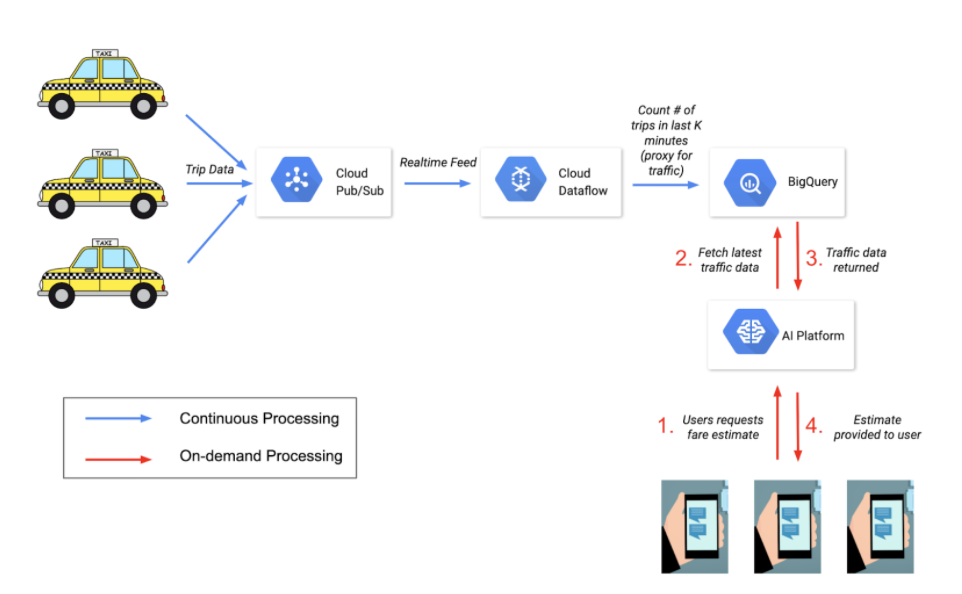

In this lab we will address how to process real-time data for machine learning models. We will use the same data as our previous 'taxifare' labs, but with the addition of trips_last_5min data as an additional feature. This is our proxy for real-time traffic.

In [1]:
# !sudo chown -R jupyter:jupyter /home/jupyter/training-data-analyst

In [2]:
!pip install --user google-cloud-bigquery==1.25.0

In [3]:
!pip install --user apache-beam[gcp]

  Using cached google_cloud_bigquery-1.17.1-py2.py3-none-any.whl (142 kB)
  Using cached google_resumable_media-0.4.1-py2.py3-none-any.whl (38 kB)


  Attempting uninstall: google-resumable-media
    Found existing installation: google-resumable-media 0.5.1
    Uninstalling google-resumable-media-0.5.1:
      Successfully uninstalled google-resumable-media-0.5.1
  Attempting uninstall: google-cloud-bigquery
    Found existing installation: google-cloud-bigquery 1.25.0
    Uninstalling google-cloud-bigquery-1.25.0:
      Successfully uninstalled google-cloud-bigquery-1.25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-storage 1.28.1 requires google-resumable-media<0.6dev,>=0.5.0, but you have google-resumable-media 0.4.1 which is incompatible.
cartoframes 1.0b3 requires google-cloud-bigquery<2.0,>=1.19.0, but you have google-cloud-bigquery 1.17.1 which is incompatible.


Kindly ignore the deprecation warnings and incompatibility errors related to google-cloud-storage.

Restart the kernel before proceeding further (On the Notebook menu - Kernel - Restart Kernel).

In [4]:
import os
import googleapiclient.discovery
import shutil

from google.cloud import bigquery
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.models import Sequential

print(tf.__version__)

2.3.1


In [5]:
PROJECT = 'buddie-270710' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'buddie_rec_data' # REPLACE WITH YOUR BUCKET NAME
REGION = 'europe-west4' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1

In [6]:
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

## Re-train our model with trips_last_5min feature
In this lab, we want to show how to process real-time data for training and prediction. So, we need to retrain our previous model with this additional feature. Go through the notebook training-data-analyst/courses/machine_learning/deepdive2/building_production_ml_systems/solutions/4a_streaming_data_training.ipynb. Open and run the notebook to train and save a model. This notebook is very similar to what we did in the Introduction to Tensorflow module but note the added feature for trips_last_5min in the model and the dataset.

## Simulate Real Time Taxi Data
Since we don’t actually have real-time taxi data we will synthesize it using a simple python script. The script publishes events to Google Cloud Pub/Sub.

Inspect the iot_devices.py script in the taxicab_traffic folder. It is configured to send about 2,000 trip messages every five minutes with some randomness in the frequency to mimic traffic fluctuations. These numbers come from looking at the historical average of taxi ride frequency in BigQuery.

In production this script would be replaced with actual taxis with IoT devices sending trip data to Cloud Pub/Sub.

To execute the iot_devices.py script, launch a terminal and navigate to the training-data-analyst/courses/machine_learning/deepdive2/building_production_ml_systems/solutions directory. Then run the following two commands.

```bash
PROJECT_ID=$(gcloud config list project --format "value(core.project)")
python3 ./iot_devices.py --project=$PROJECT_ID
```
You will see new messages being published every 5 seconds. **Keep this terminal open** so it continues to publish events to the Pub/Sub topic. If you open [Pub/Sub](https://console.cloud.google.com/cloudpubsub/topic/list) in your Google Cloud Console, you should be able to see a topic called taxi_rides.

## Create a BigQuery table to collect the processed data

In the next section, we will create a dataflow pipeline to write processed taxifare data to a BigQuery Table, however that table does not yet exist. Execute the following commands to create a BigQuery dataset called taxifare and a table within that dataset called traffic_realtime.

In [11]:
bq = bigquery.Client()

dataset = bigquery.Dataset(bq.dataset("buddieRec"))
try:
    bq.create_dataset(dataset)  # will fail if dataset already exists
    print("Dataset created.")
except:
    print("Dataset already exists.")

Dataset already exists.


In [12]:
dataset = bigquery.Dataset(bq.dataset("buddieRec"))

table_ref = dataset.table("rec_realtime")
SCHEMA = [
    bigquery.SchemaField("changedPages_last_5min", "INTEGER", mode="REQUIRED"),
    bigquery.SchemaField("time", "TIMESTAMP", mode="REQUIRED"),
]
table = bigquery.Table(table_ref, schema=SCHEMA)

try:
    bq.create_table(table)
    print("Table created.")
except:
    print("Table already exists.")

Table already exists.


## Launch Streaming Dataflow Pipeline
Now that we have our taxi data being pushed to Pub/Sub, and our BigQuery table set up, let’s consume the Pub/Sub data using a streaming DataFlow pipeline.

The pipeline is defined in `./taxicab_traffic/streaming_count.py.` Open that file and inspect it.

There are 5 transformations being applied:

- Read from PubSub
- Window the messages
- Count number of messages in the window
- Format the count for BigQuery
- Write results to BigQuery

TODO 1: Leave the second transform in ./taxicab_traffic/streaming_count.py as a TODO: Specify a sliding window that is 5 minutes long, and gets recalculated every 15 seconds. Hint: Reference the [beam programming guide](https://beam.apache.org/documentation/programming-guide/#windowing) for guidance. To check your answer reference the solution.

For the second transform, we specify a sliding window that is 5 minutes long, and recalculate values every 15 seconds.

In a new terminal, launch the dataflow pipeline using the command below. You can change the BUCKET variable, if necessary. Here it is assumed to be your PROJECT_ID.

```bash
PROJECT_ID=$(gcloud config list project --format "value(core.project)")
BUCKET=buddie_rec_data # CHANGE AS NECESSARY 
python3 ./streaming_count.py \
    --input_topic=buddie_recs \
    --runner=DataflowRunner \
    --project=$PROJECT_ID \
    --temp_location=gs://$BUCKET/dataflow_streaming
```

Once you've submitted the command above you can examine the progress of that job in the [Dataflow section of Cloud console](https://console.cloud.google.com/dataflow/jobs?project=buddie-270710&folder=&organizationId=)

## Explore the data in the table
After a few moments, you should also see new data written to your BigQuery table as well.

Re-run the query periodically to observe new data streaming in! You should see a new row every 15 seconds.


In [42]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [43]:
%%bigquery
SELECT
  *
FROM
  `buddieRec.rec_realtime`
ORDER BY
  time DESC
LIMIT 10

changedPages_last_5min                      time
0                    1694 2021-02-08 18:26:08+00:00
1                    1791 2021-02-08 18:26:04+00:00
2                    1805 2021-02-08 18:26:04+00:00
3                    1789 2021-02-08 18:25:28+00:00
4                    1793 2021-02-08 18:25:27+00:00
5                    1700 2021-02-08 18:25:20+00:00
6                    1639 2021-02-08 18:24:40+00:00
7                    1539 2021-02-08 18:24:39+00:00
8                    1451 2021-02-08 18:24:10+00:00
9                    1267 2021-02-08 18:23:53+00:00

## Make predictions from the new data
In the rest of the lab, we'll referece the model we trained and deployed from the previous labs, so make sure you have run the code in the 1_streaming_data_training.ipynb notebook.

The add_rec_last_5min function below will query the traffic_realtime table to find the most recent traffic information and add that feature to our instance for prediction.

In [44]:
# TODO 2a. Write a function to take most recent entry in `traffic_realtime` table and add it to instance.
def add_changedPages_last_5min(instance):
    bq = bigquery.Client()
    query_string = """
    SELECT
      *
    FROM
      `buddieRec.rec_realtime`
    ORDER BY
      time DESC
    LIMIT 1
    """
    changedPages = bq.query(query_string).to_dataframe()['changedPages_last_5min']
    print(changedPages)
    instance['changedPages'] = int(changedPages)
    return instance

The traffic_realtime table is updated in realtime using Cloud Pub/Sub and Dataflow so, if you run the cell below periodically, you should see the traffic_last_5min feature added to the instance and change over time.

In [45]:
add_changedPages_last_5min(instance={"clientId": 160145,
                                    "organization": "leeromgeving"})

0    1694
Name: changedPages_last_5min, dtype: int64


{'clientId': 160145, 'organization': 'leeromgeving', 'changedPages': 1694}

Finally, we'll use the python api to call predictions on an instance, using the realtime traffic information in our prediction. Just as above, you should notice that our resulting predicitons change with time as our realtime traffic information changes as well.

In [53]:
!pip install httplib2 --upgrade

In [64]:
# # TODO 2b. Write code to call prediction on instance using realtime traffic info.
# #Hint: Look at the "Serving online predictions" section of this page https://cloud.google.com/ml-engine/docs/tensorflow/custom-prediction-routine-keras
# MODEL_NAME = 'tfrs_rec'
# VERSION_NAME = 'streaming_test'

# service = googleapiclient.discovery.build('europe-west4-ml', 'v1', cache_discovery=False)
# name = 'projects/{}/models/{}/versions/{}'.format(PROJECT,
#                                                   MODEL_NAME,
#                                                   VERSION_NAME)

# instance = add_changedPages_last_5min({"clientId": 160145,
#                                   "organization": "leeromgeving"})

# response = service.projects().predict(
#     name=name,
#     body={'instances': [instance]}
# ).execute()

# if 'error' in response:
#     raise RuntimeError(response['error'])
# else:
#     print(response['predictions'][0]['output_1'][0])

In [63]:
from oauth2client.client import GoogleCredentials
import requests
import json

MODEL_NAME="tfrs_rec"
MODEL_VERSION="streaming_test"

token = GoogleCredentials.get_application_default().get_access_token().access_token
api = 'https://europe-west4-ml.googleapis.com/v1/projects/{}/models/{}/versions/{}:predict' \
         .format(PROJECT, MODEL_NAME, MODEL_VERSION)
headers = {'Authorization': 'Bearer ' + token}


data = {
  'instances': [add_changedPages_last_5min({"clientId": '160145',
                                 "organization": "leeromgeving"})]
}

response = requests.post(api, json=data, headers=headers)
print(response.content)

0    309
Name: changedPages_last_5min, dtype: int64
b'{\n    "predictions": [\n        {\n            "output_1": [18.6644478, 15.3845987, 14.2674255, 13.3526211, 11.9929581, 10.9048853, 10.8844452, 10.0779972, 9.73279762, 9.24139881],\n            "output_2": ["/content/video/4813", "/content/mix/7546", "/content/video/1068", "/content/mix/3046", "/content/mix/3030", "/content/mix/1508", "/content/mix/3000", "/content/video/2926", "/content/mix/2972", "/content/mix/2966"]\n        }\n    ]\n}'


Copyright 2019 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License